In [2]:
import pandas as pd
from core import med_log_odds_cutoff
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from joblib import Parallel, delayed

In [50]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
seq_id_accessions = pd.read_parquet('../data/interim/seq_id_accessions.pq')
df_true_df = pd.read_parquet('../data/interim/defense_finder_genes_genomes.pq')
df_homolog_df = pd.read_parquet('../data/interim/defense_finder_homologs_profile_names.pq')
df_homolog_df = df_homolog_df.merge(seq_id_accessions, how='inner', on='seq_id')

In [5]:
%%time
seq_assemblies = pd.read_csv('../data/interim/seq_assemblies.csv', 
                             names=['product_accession', 'seq_id', 'seq', 'assembly'])

CPU times: user 4min 25s, sys: 25.6 s, total: 4min 51s
Wall time: 4min 51s


In [6]:
%%time
cluster_df = pd.read_parquet('../data3/interim/refseq_cover_clusters.pq')

CPU times: user 24.6 s, sys: 8.97 s, total: 33.6 s
Wall time: 28.4 s


In [7]:
unqiue_df_homolog_df = (df_homolog_df.groupby('seq_id')
                        .sample(n=1, random_state=7))

In [8]:
prediction_out_dir = '../data3/interim/refseq1k_preds/'

In [9]:
predictions = pd.concat([pd.read_parquet(prediction_out_dir + f) for 
                         f in tqdm(os.listdir(prediction_out_dir)) if '_predictions.pq' in f])

100%|██████████| 1998/1998 [00:58<00:00, 34.16it/s]


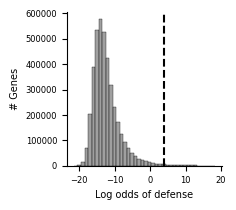

In [51]:
plt.subplots(figsize=(2,2))
sns.histplot(predictions['mean_log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()

In [11]:
predictions['predicted_defensive'] = predictions['mean_log_odds'] > med_log_odds_cutoff

In [12]:
predictions['predicted_defensive'].sum()

32491

In [13]:
unique_true_df = (df_true_df.sort_values('sys_score', ascending=False)
                  .groupby(['genome', 'protein_accession'])
                  .head(1))

In [14]:
refseq_1k_seqs = seq_assemblies.loc[seq_assemblies['product_accession']
                                   .isin(predictions['product_accession'].unique()), 
                                   ['product_accession', 'seq', 'seq_id']].drop_duplicates()


In [15]:
merged_predictions = (predictions.merge(unqiue_df_homolog_df.rename(columns={'protein_accession': 'product_accession', 
                                                                             'gene_name': 'defense_homolog_name'})
                                        .drop(columns='seq_id'), 
                                        how='left', on='product_accession'))
merged_predictions['defense_homolog'] = ~merged_predictions['defense_homolog_name'].isna()
merged_predictions['assembly_stub'] = merged_predictions['assembly'].str.split('.', expand=True)[0]
merged_predictions = (merged_predictions.merge(unique_true_df[['genome', 'protein_accession','gene_name', 'sys_id']]
                                               .rename(columns={'genome': 'assembly_stub', 
                                                                'protein_accession': 'product_accession', 
                                                                'gene_name': 'defense_system_gene', 
                                                                'sys_id': 'defense_system'}), 
                                               how='left', on=['product_accession', 'assembly_stub']))
merged_predictions['defense_system_protein'] = ~merged_predictions['defense_system_gene'].isna()
merged_predictions = (merged_predictions
                      .merge(refseq_1k_seqs, how='inner', on='product_accession')
                      .merge(cluster_df, how='inner', on='seq_id'))

In [16]:
len(merged_predictions) == len(predictions)

True

In [17]:
cluster_count = (merged_predictions
                 .groupby('cluster_id')
                 .agg(n_assemblies=('assembly', 'nunique'))
                 .reset_index(drop=True))

In [18]:
assemblies = merged_predictions['assembly'].drop_duplicates()
n_assemblies = len(assemblies)
n_assemblies

999

In [19]:
len(cluster_count)

740809

In [20]:
(cluster_count['n_assemblies'] <= 10).sum()

696455

In [21]:
(cluster_count['n_assemblies'] >= 900).sum()

80

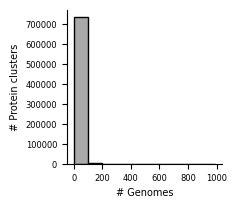

In [52]:
plt.subplots(figsize=(2,2))
sns.histplot(data=cluster_count, x='n_assemblies',binwidth=100, color='darkgrey', alpha=1)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/refseq_1k_u_plot.svg', dpi=300, bbox_inches='tight')

In [23]:
n_samples = [int(x) for x in np.linspace(1, len(assemblies), num=50)]
n_boot = 10

In [24]:
del seq_assemblies, cluster_df

In [25]:
n_clusters_per_assembly_list = list()
for n in tqdm(n_samples, position=0):
    for boot in range(n_boot):
        sampled_assemblies = set(assemblies.sample(n=n, random_state=boot))
        n_clusters = merged_predictions.loc[merged_predictions['assembly'].isin(sampled_assemblies), 
                                              'cluster_id'].nunique()
        n_clusters_per_assembly_list.append({'n_assemblies': n,
                                             'n_clusters': n_clusters, 
                                             'boot': boot})

100%|██████████| 50/50 [05:27<00:00,  6.54s/it]


In [26]:
n_clusters_per_assembly_df = pd.DataFrame(n_clusters_per_assembly_list)

In [27]:
agg_n_clusters_per_assembly = (n_clusters_per_assembly_df
                               .groupby('n_assemblies')
                               .agg({'n_clusters': 'mean'})
                               .reset_index())

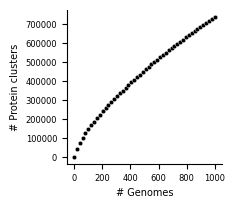

In [53]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_clusters_per_assembly, x='n_assemblies', y='n_clusters',
                color='black', s=10)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/refseq_1k_clusters_per_assembly.svg', dpi=300, bbox_inches='tight')

In [29]:
assembly_n_genes = (merged_predictions.groupby('assembly')
                    .agg(total_genes=('product_accession', 'count'), 
                         predicted_defense_genes=('predicted_defensive', 'sum'), 
                         known_defense_genes=('defense_system_protein', 'sum'))
                    .reset_index())
assembly_n_genes['perc_predicted_defensive'] = (assembly_n_genes['predicted_defense_genes']/assembly_n_genes['total_genes'])*100
assembly_n_genes['perc_known_defensive'] = (assembly_n_genes['known_defense_genes']/assembly_n_genes['total_genes'])*100


In [30]:
assembly_n_genes[['perc_predicted_defensive', 'perc_known_defensive', 
                  'predicted_defense_genes', 'known_defense_genes']].mean()

perc_predicted_defensive     0.867404
perc_known_defensive         0.388014
predicted_defense_genes     32.523524
known_defense_genes         13.859860
dtype: float64

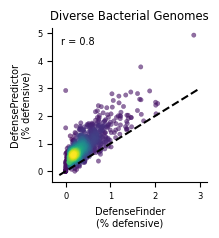

In [54]:
plt.subplots(figsize=(2,2))
gpplot.point_densityplot(data=assembly_n_genes, 
                         x='perc_known_defensive', 
                         y='perc_predicted_defensive',  
                         s=10)
gpplot.add_correlation(data=assembly_n_genes, 
                       x='perc_predicted_defensive', 
                       y='perc_known_defensive', 
                       fontfamily='Sans-Serif')
plt.xlabel('DefenseFinder\n(% defensive)')
plt.ylabel('DefensePredictor\n(% defensive)')
sns.despine()
gpplot.add_xy_line()
plt.title('Diverse Bacterial Genomes')
plt.savefig('../figures/systems_df_dp.svg', dpi=300, bbox_inches='tight')

In [32]:
assembly_n_genes.sort_values('perc_predicted_defensive')

,assembly,total_genes,predicted_defense_genes,known_defense_genes,perc_predicted_defensive,perc_known_defensive
499,GCF_008189685.1,576,0,0,0.000000,0.000000
53,GCF_000292685.1,249,0,0,0.000000,0.000000
997,GCF_936981045.1,805,0,0,0.000000,0.000000
54,GCF_000319245.1,736,0,0,0.000000,0.000000
745,GCF_018107685.1,669,0,0,0.000000,0.000000
...,...,...,...,...,...,...
818,GCF_021390715.1,2265,65,33,2.869757,1.456954
427,GCF_004341395.1,2820,82,53,2.907801,1.879433
295,GCF_002999455.1,684,20,0,2.923977,0.000000
247,GCF_002149925.1,3334,126,56,3.779244,1.679664


In [33]:
cluster_defense_frac = (merged_predictions.groupby('cluster_id')
                        .agg(mean_defensive=('predicted_defensive', 'mean'), 
                             members=('seq_id', 'count'))
                        .reset_index())

In [34]:
(cluster_defense_frac['mean_defensive'] == 1).sum()

13340

In [35]:
(cluster_defense_frac
 .query('mean_defensive > 0')
 .query('members >= 3')
 ['mean_defensive'] >= 0.5).sum()

2385

In [36]:
len(cluster_defense_frac
 .query('mean_defensive > 0')
 .query('members >= 3'))

3305

In [56]:
2385/3305

0.7216338880484114

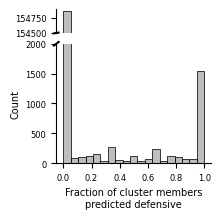

In [64]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                                      gridspec_kw={'hspace':0.15}, 
                                      figsize=(2, 2), 
                                      height_ratios=[1,5])
sns.histplot(data=cluster_defense_frac[cluster_defense_frac['members'] >= 3], 
             x='mean_defensive', color='darkgrey', ax=ax_bottom)
sns.histplot(data=cluster_defense_frac[cluster_defense_frac['members'] >= 3], 
             x='mean_defensive', color='darkgrey', ax=ax_top)
ax_top.set_ylim(154_900-2_000*1/5, 154_900)   
ax_bottom.set_ylim(0,2_000)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax_top.xaxis.set_visible(False)
ax_top.set_ylabel('')

kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax_bottom.set_xlabel("Fraction of cluster members\n"
           "predicted defensive")
plt.savefig('../figures/refseq_1k_cluster_frac_defensive.svg', bbox_inches='tight')

In [38]:
predicted_defense_clusters = merged_predictions.query('predicted_defensive')['cluster_id'].drop_duplicates()

In [39]:
defense_cluster_predictions = (merged_predictions[merged_predictions['cluster_id'].isin(predicted_defense_clusters)]
                               .reset_index(drop=True))

In [40]:
defense_cluster_predictions

,protein_context_id,mean_log_odds,sd_log_odds,min_log_odds,max_log_odds,# feature,class,assembly,assembly_unit,seq_type,...,predicted_defensive,defense_homolog_name,defense_homolog,assembly_stub,defense_system_gene,defense_system,defense_system_protein,seq,seq_id,cluster_id
0,WP_021762915.1|NZ_JACCFL010000001.1|4869|-,9.956518,1.078914,8.358637,11.564667,CDS,with_protein,GCF_013410375.1,Primary Assembly,unplaced scaffold,...,True,NaN,False,GCF_013410375,NaN,NaN,False,MEEQYSPRYTRLDAFESAAAQAAGAVLQHAFDRLTSLIESGRTVVS...,0a256e5aabab5d7489692acfc9ddff285c4fd3c7faa30c...,0a256e5aabab5d7489692acfc9ddff285c4fd3c7faa30c...
1,WP_021762916.1|NZ_JACCFL010000001.1|3943|+,6.790493,1.828072,3.456329,8.367027,CDS,with_protein,GCF_013410375.1,Primary Assembly,unplaced scaffold,...,True,NaN,False,GCF_013410375,NaN,NaN,False,MDLSQEEARRLRILAALFELAGHHTASDVSLAELNDKLIQMRDLGS...,dced1660071fb17d7aded1a9f67d5b7fcaa4414502c49b...,87577f2aa7c965ffa8a4b5ea9bef5b6894801368bdc6ab...
2,WP_039921959.1|NZ_JACCFL010000001.1|39549|+,4.240073,1.144081,3.056098,6.280027,CDS,with_protein,GCF_013410375.1,Primary Assembly,unplaced scaffold,...,True,NaN,False,GCF_013410375,NaN,NaN,False,MDFWQQFWATMWGALAGAIVAGGVTVFVAWRSWAVSRDSQYRDRFD...,29b755ab6d8429c77b67dab4d9c67e99213cb4f662cf87...,29b755ab6d8429c77b67dab4d9c67e99213cb4f662cf87...
3,WP_179603977.1|NZ_JACCFL010000001.1|138804|-,-2.019759,2.025559,-6.016954,-0.465172,CDS,with_protein,GCF_013410375.1,Primary Assembly,unplaced scaffold,...,False,NaN,False,GCF_013410375,NaN,NaN,False,MRQGPGQGAESTLVTASSPAFALPENLHAKSAPALIADDERHFAAI...,2b14780b484861cd7f05bb3692cddf39de53311c720289...,721e4c9417b8e912e829a3bf0e948ac6328f17f9e2ff59...
4,WP_179604146.1|NZ_JACCFL010000001.1|342732|-,1.574364,2.060194,-1.411895,4.834469,CDS,with_protein,GCF_013410375.1,Primary Assembly,unplaced scaffold,...,False,NaN,False,GCF_013410375,NaN,NaN,False,MTMEPNRAEAEHDYGANEIQILEGLEAVRKRPGMYIGSTGPRGLHH...,df2b019cc21fd74a33718bc0c242e2ca4d549d51a77979...,986c293a4a6a3d7c881f720f4011f329eeb9128862b2aa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49384,WP_241950906.1|NZ_CP093334.1|2508122|+,4.586210,1.208984,2.822729,6.178513,CDS,with_protein,GCF_022637595.1,Primary Assembly,chromosome,...,True,DISARM_1__drmD,True,GCF_022637595,NaN,NaN,False,MQITEYHAKYYAHELTCLHAADSVDRLSQSLFDATVDLNPHQIEAA...,67339af8e87b2b8dc3fd846c7b5f6eaf27ab2a55eec592...,d56011618cd3cb7b30dcb3e32ba8d3bdbbd0cbf4ce8046...
49385,WP_241950907.1|NZ_CP093334.1|2511118|+,11.257812,2.456174,6.828589,13.392220,CDS,with_protein,GCF_022637595.1,Primary Assembly,chromosome,...,True,RM_Type_II__Type_II_MTases,True,GCF_022637595,NaN,NaN,False,MSKFNELVTKLREVFQIDRPELDFGVYRILNARADEINEYLEKRLK...,9b094fea70db9755819bb78ffc3e94886e39575cd3343f...,0fb403a23fc30eafc899dfba6d6cdd5a198d28d9040bc9...
49386,WP_241950908.1|NZ_CP093334.1|2514540|+,7.246435,0.663222,6.555775,8.491685,CDS,with_protein,GCF_022637595.1,Primary Assembly,chromosome,...,True,NaN,False,GCF_022637595,NaN,NaN,False,MAFPKTAAKTKLKKRSFHQELVLNRWMMRFFKGNELAALKLRLGDD...,a52eb803c345c76b34a38dffba63331ee18bc6e521b938...,378f81814893eea527965f358905a6d0dcf73b37b9f04d...
49387,WP_241950967.1|NZ_CP093334.1|4338299|+,9.544392,2.546536,5.904395,13.398849,CDS,with_protein,GCF_022637595.1,Primary Assembly,chromosome,...,True,NaN,False,GCF_022637595,NaN,NaN,False,MPVHHAIWRVGETPQPLTISKLATEKLLQKMIIQDSSILSDQWMII...,111b738d0581cdd64bb3324da56fde9e6399f938f29242...,1742a38689e526ce282515099c505d0d04d9cb59d4b206...


## Get potential novel hits to query with HHblits

In [41]:
def assign_predicted_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    else:
        return 'Putative novel defense gene'

In [42]:
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Putative novel defense gene']
predicted_defense_df = merged_predictions[merged_predictions['predicted_defensive']].copy()
predicted_defense_df['predicted_category'] = predicted_defense_df.apply(assign_predicted_category, axis=1)
predicted_defense_df['predicted_category'] = pd.Categorical(predicted_defense_df['predicted_category'], 
                                                    categories=hit_categories)

In [43]:
predicted_defense_df['predicted_category'].value_counts()

predicted_category
Putative novel defense gene           14734
Defense homolog in expected system     9810
Defense homolog in new context         7947
Name: count, dtype: int64

In [44]:
non_redundant_predictions = (predicted_defense_df
                             .sort_values(['predicted_category', 'mean_log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [45]:
non_redundant_predictions['predicted_category'].value_counts()

predicted_category
Putative novel defense gene           9670
Defense homolog in expected system    3448
Defense homolog in new context        2706
Name: count, dtype: int64

In [46]:
putative_novel_df = non_redundant_predictions[non_redundant_predictions['predicted_category'] == 'Putative novel defense gene'].copy()

In [47]:
putative_novel_df['name'].value_counts().head(50)

name
hypothetical protein                                                   6991
ATP-binding protein                                                     148
restriction endonuclease                                                104
DUF2971 domain-containing protein                                        93
HEPN domain-containing protein                                           91
HNH endonuclease                                                         75
AAA family ATPase                                                        74
PD-(D/E)XK nuclease family protein                                       69
PIN domain-containing protein                                            69
DUF262 domain-containing protein                                         68
DUF5677 domain-containing protein                                        51
DUF4238 domain-containing protein                                        43
DUF4365 domain-containing protein                                        42
DUF4145

In [48]:
putative_novel_seqs = refseq_1k_seqs[refseq_1k_seqs['product_accession'].isin(putative_novel_df['product_accession'])]

In [49]:
len(putative_novel_seqs)

9670

In [65]:
with open('../data3/interim/refseq_1k_putative_novel_seqs.faa', 'w') as f:
    for _, row in putative_novel_seqs.iterrows():
        print('>' + row['product_accession'], file=f)
        print(row['seq'], file=f)

In [66]:
merged_predictions.drop(columns='chromosome').to_parquet('../data3/processed/refseq_1k_predictions.pq', index=False)